## Test for Feature Eng 536 feat - LightGBM

In [5]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('darkgrid')
import datetime
import missingno as msno
import lightgbm as lgb
import xgboost as xgb
from sklearn import preprocessing
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import KFold, TimeSeriesSplit, train_test_split,StratifiedKFold
import gc
from statistics import mean
import pickle
# Any results you write to the current directory are saved as output.

### Setup Cross Validation
1. Divide Train set in subsets (Training set itself + Local Test set)
2. Define Validation Metric (in our case it is ROC-AUC)
3. Stop training when Validation metric stops improving
4. Take average of each fold's prediction for the Local Test set.

In [6]:
train_full = pd.read_pickle('data/train_feat.pkl')
test_full = pd.read_pickle('data/test_feat.pkl')

# Not using the below since the object type is all converted to category type already
# Label Encoding for categoricals
for f in test_full.columns:
    if train_full[f].dtype=='object' or test_full[f].dtype=='object': 
        train_full[f] = train_full[f].fillna('unseen_before_label')
        test_full[f]  = test_full[f].fillna('unseen_before_label')
        lbl = preprocessing.LabelEncoder()
        lbl.fit(list(train_full[f].values) + list(test_full[f].values))
        train_full[f] = lbl.transform(list(train_full[f].values))
        test_full[f] = lbl.transform(list(test_full[f].values)) 

# Fill NA's for numerics
train_full = train_full.fillna(-999)
test_full = test_full.fillna(-999)

In [7]:
with open('data/corr_feat.pkl', 'rb') as f:
    correlated_features = pickle.load(f)
    
rm_cols = [
    'TransactionID','TransactionDT', 
    'isFraud',
    'id_31', # remove time dependent features - these cause model to overfit too much
#     'V300','V309','V111','V124','V106','V125','V315','V134','V102','V123','V316','V113',
#               'V136','V305','V110','V299','V289','V286','V318','V304','V116','V284','V293',
#               'V137','V295','V301','V104','V311','V115','V109','V119','V321','V114','V133','V122','V319',
#               'V105','V112','V118','V117','V121','V108','V135','V320','V303','V297','V120',
#               'V1','V14','V41','V65','V88', 'V89', 'V107', 'V68', 'V28', 'V27', 'V29', 'V241','V269',
#               'V240', 'V325', 'V138', 'V154', 'V153', 'V330', 'V142', 'V195', 'V302', 'V328', 'V327', 
#               'V198', 'V196', 'V155' # remove bunch of V features
] + correlated_features

# Final features
features_columns = [col for col in list(train_full.columns) if col not in rm_cols]

In [8]:
X = train_full[features_columns]
y = train_full['isFraud']

# # Split holdout as 15% of the train set
# X, X_holdout, y, y_holdout = train_test_split(train_full[features_columns], train_full['isFraud'], 
#                                               test_size=0.15, random_state=42, shuffle=False)
# #                                               stratify = train_full['isFraud'])

del train_full
gc.collect()

61

In [9]:
params = {
                    'objective':'binary',
                    'boosting_type':'gbdt',
                    'metric':'auc',
                    'n_jobs':-1,
                    'learning_rate':0.01, # speed up the learning rate a bit - might sacrifice a bit of accuracy
                    'num_leaves':2**8, # reduce number of leaves to reduce overfitting
                    'max_depth': -1, # max_depth should be constrained, -1 would mean unconstrained
                    'tree_learner':'serial',
                    'colsample_bytree': 0.7,
                    'subsample_freq':1,
                    'subsample':0.7,
                    'n_estimators':800,
                    'max_bin':255, # less bins if overfitting
                    'verbose':-1,
                    'seed': 2019,
                    'early_stopping_rounds':100,
#                     'lambda_l1':5,
#                     'lambda_l2':5,
                } 

In [10]:
NFOLDS =5
# folds = StratifiedKFold(n_splits=NFOLDS,random_state=123,shuffle=False) # split by stratified folds. Do shuffle =F
folds = KFold(n_splits=NFOLDS,random_state=123,shuffle=False) # split by stratified folds
# folds = TimeSeriesSplit(n_splits=NFOLDS) # split by time - try timeseries split, perhaps less overfitting? result: worse overfitting

aucs = []
clfs=[]
pred_len = len(test_full)
prediction = np.zeros(pred_len)

for fold, (trn_idx, test_idx) in enumerate(folds.split(X,y)):
    print('Training on fold {}'.format(fold + 1))
    
    trn_data = lgb.Dataset(data=X.iloc[trn_idx], label=y.iloc[trn_idx])
    val_data = lgb.Dataset(data=X.iloc[test_idx], label=y.iloc[test_idx])
    clf = lgb.train(params, 
                    trn_data, 
                    valid_sets = [trn_data, val_data], 
                    verbose_eval=200)
    
    print('AUC for validation fold {}: {}'.format(fold+1, clf.best_score['valid_1']['auc']))
    aucs.append(clf.best_score['valid_1']['auc'])
    
#     holdout_pred = clf.predict(X_holdout)
#     print('AUC for holdout set - fold ', roc_auc_score(y_holdout, holdout_pred))
    
    prediction += clf.predict(test_full[features_columns])

print("Cross Validation AUC: ", sum(aucs)/NFOLDS)
final_predictions = prediction/NFOLDS

Training on fold 1


C:\Users\martin.cheung\AppData\Local\Continuum\anaconda3\lib\site-packages\lightgbm\engine.py:113: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\martin.cheung\AppData\Local\Continuum\anaconda3\lib\site-packages\lightgbm\engine.py:118: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 100 rounds.
[200]	training's auc: 0.963725	valid_1's auc: 0.896518
[400]	training's auc: 0.988254	valid_1's auc: 0.912553
[600]	training's auc: 0.995797	valid_1's auc: 0.919784
[800]	training's auc: 0.998468	valid_1's auc: 0.923026
Did not meet early stopping. Best iteration is:
[800]	training's auc: 0.998468	valid_1's auc: 0.923026
AUC for validation fold 1: 0.923025822901945
Training on fold 2
Training until validation scores don't improve for 100 rounds.
[200]	training's auc: 0.962448	valid_1's auc: 0.914291
[400]	training's auc: 0.989326	valid_1's auc: 0.930882
[600]	training's auc: 0.996646	valid_1's auc: 0.93651
[800]	training's auc: 0.998875	valid_1's auc: 0.938321
Did not meet early stopping. Best iteration is:
[800]	training's auc: 0.998875	valid_1's auc: 0.938321
AUC for validation fold 2: 0.938321477943722
Training on fold 3
Training until validation scores don't improve for 100 rounds.
[200]	training's auc: 0.964562	valid_1

#### Model Iterations Done in This Notebook:
- Using 470 Features -> Slight improvement: CV: 0.9340; LB: 0.9437
- Using 536 Features -> CV: 0.9356; LB: 0.9447
- Remove feature id_31 (browser version encodes time which might cause overfit) -> CV: 0.9356; LB: 0.9450
- Remove bunch of V features -> CV: 0.9361; LB: 0.9448 (slightly less overfit)
- Remove >=98% correlated variables -> CV: 0.9354; LB: 0.9461
- Final Feature Engineering Step using ideas from other kernels (550 feat minus correlated feat) -> CV: 0.9361; LB: 0.9461

** Data leakage in feature engineering process found when creating frequency encoding - FIXED

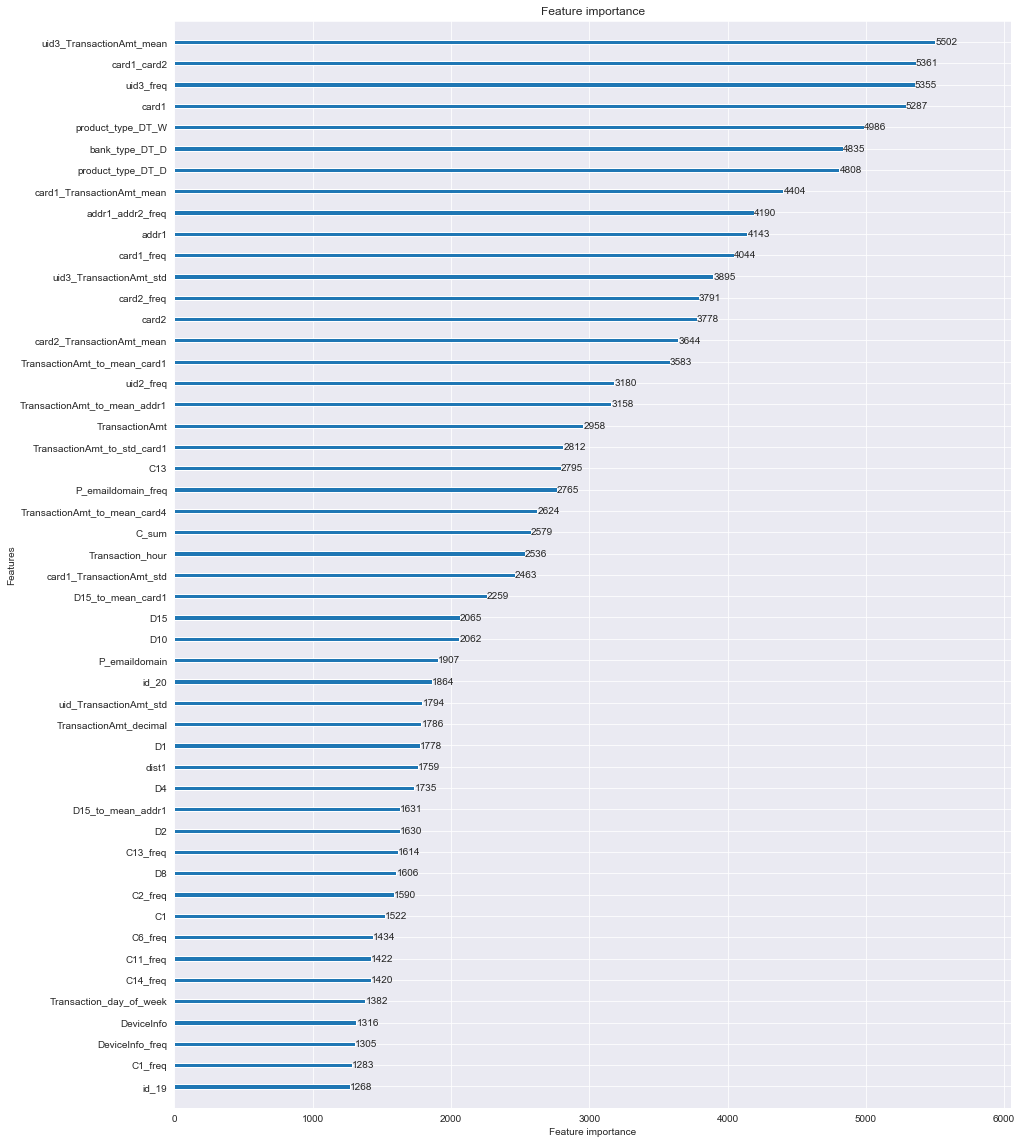

In [11]:
fig, ax = plt.subplots(figsize=(15, 20))
lgb.plot_importance(clf,max_num_features=50,ax=ax)
# for i in range(NFOLDS):
#     fig, ax = plt.subplots(figsize=(15, 20))
#     xgb.plot_importance(clfs[i],max_num_features=50,ax=ax)

In [12]:
sample_submission = pd.read_csv('data/sample_submission.csv', index_col='TransactionID')
sample_submission['isFraud'] = prediction
sample_submission.to_csv('data/lightgbm_finalfeat.csv')